# Sudoku Masked Diffusion Model (MDM)

This notebook demonstrates training and using a **Masked Diffusion Model** for Sudoku generation. The model learns to iteratively unmask positions, outputting per-position marginal distributions p(x_i | context) that we'll later use for **mutual information estimation**.

## Objectives
1. Train an MDM on Sudoku puzzles
2. Generate valid Sudoku solutions through iterative unmasking
3. Analyze per-position marginal distributions
4. Prepare foundation for MI estimation (Options A, B1, B2)


## 1. Import Required Libraries

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import math

# Import from our sudoku.py module
sys.path.append('.')
from sudoku import (
    SudokuDataset, SudokuMDM, MDMTrainer, MDMSampler,
    MaskSchedule, check_sudoku_valid, evaluate_samples
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.9.1+cu128


## 2. Load and Prepare Sudoku Dataset

We'll generate a small dataset for quick experimentation.

In [11]:
# Check if datasets exist, otherwise generate
data_dir = Path('data')

train_dataset = SudokuDataset(data_path=str(data_dir / 'sudoku.csv'), num_samples=100000)
val_dataset = SudokuDataset(data_path=str(data_dir / 'sudoku.csv'), num_samples=1000, start_idx=100000)

print(f"\nDataset sizes:")
print(f"  Training: {len(train_dataset)} puzzles")
print(f"  Validation: {len(val_dataset)} puzzles")

# Show a sample
puzzle, solution = train_dataset[0]
print(f"\nSample puzzle shape: {puzzle.shape}")
print(f"Sample solution shape: {solution.shape}")


Loading Sudoku from CSV: data/sudoku.csv (start=0, n=100000)
✓ Loaded 100000 puzzles from CSV: data/sudoku.csv
Loading Sudoku from CSV: data/sudoku.csv (start=100000, n=1000)
✓ Loaded 1000 puzzles from CSV: data/sudoku.csv

Dataset sizes:
  Training: 100000 puzzles
  Validation: 1000 puzzles

Sample puzzle shape: torch.Size([81])
Sample solution shape: torch.Size([81])


## 3. Define Sudoku Visualization Utilities

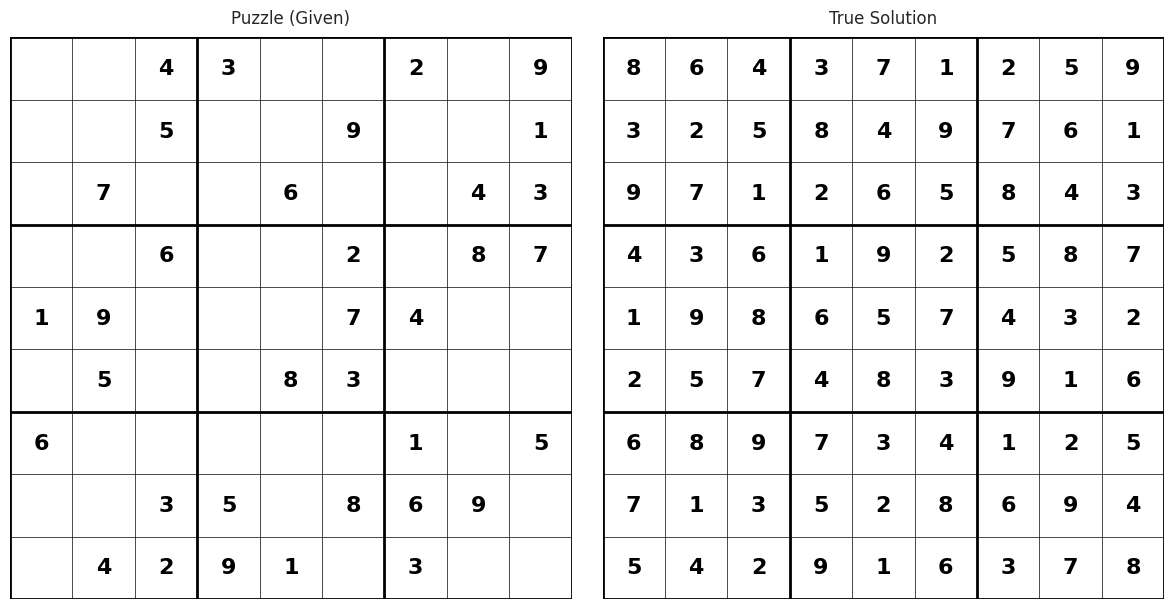

In [4]:
def plot_sudoku(board, title="Sudoku Board", figsize=(6, 6)):
    """Visualize a Sudoku board."""
    board = board.reshape(9, 9)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.plot([i, i], [0, 9], 'k-', linewidth=lw)
        ax.plot([0, 9], [i, i], 'k-', linewidth=lw)
    
    # Fill numbers
    for i in range(9):
        for j in range(9):
            val = board[i, j]
            if val != 0:
                color = 'black' if val != 0 else 'gray'
                weight = 'bold' if val != 0 else 'normal'
                ax.text(j + 0.5, 8.5 - i, str(int(val)), 
                       ha='center', va='center', fontsize=16,
                       color=color, weight=weight)
    
    ax.set_title(title, fontsize=14, pad=10)
    plt.tight_layout()
    return fig


def plot_sudoku_comparison(puzzle, solution, generated=None):
    """Compare puzzle, solution, and optionally generated solution."""
    n_plots = 3 if generated is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
    
    if n_plots == 2:
        axes = [axes[0], axes[1]]
    
    # Plot puzzle
    plot_sudoku_on_axis(axes[0], puzzle, "Puzzle (Given)")
    
    # Plot true solution
    plot_sudoku_on_axis(axes[1], solution, "True Solution")
    
    # Plot generated if provided
    if generated is not None:
        is_valid = check_sudoku_valid(generated.numpy())
        title = f"Generated Solution {'✓ Valid' if is_valid else '✗ Invalid'}"
        plot_sudoku_on_axis(axes[2], generated, title)
    
    plt.tight_layout()
    return fig


def plot_sudoku_on_axis(ax, board, title):
    """Plot Sudoku on a given axis."""
    board = board.reshape(9, 9)
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.plot([i, i], [0, 9], 'k-', linewidth=lw)
        ax.plot([0, 9], [i, i], 'k-', linewidth=lw)
    
    # Fill numbers
    for i in range(9):
        for j in range(9):
            val = board[i, j]
            if val != 0:
                ax.text(j + 0.5, 8.5 - i, str(int(val)), 
                       ha='center', va='center', fontsize=16,
                       color='black', weight='bold')
    
    ax.set_title(title, fontsize=12, pad=10)


# Test visualization
puzzle, solution = train_dataset[0]
plot_sudoku_comparison(puzzle, solution)
plt.show()


## 4. Define the MDM Model

The model architecture is already defined in `sudoku.py`. Let's create an instance and examine it.

In [5]:
# Model configuration
model_config = {
    'vocab_size': 10,  # 0 (mask) + 1-9 (digits)
    'd_model': 384,
    'nhead': 12,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'max_seq_len': 81  # 9x9 Sudoku
}

# Create model
model = SudokuMDM(**model_config).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {num_params:,} parameters")
print(f"\nModel architecture:")
print(model)


Model created with 4,158,346 parameters

Model architecture:
SudokuMDM(
  (embedding): Embedding(10, 384)
  (pos_encoder): Sudoku2DPositionalEncoding(
    (row_embedding): Embedding(9, 128)
    (col_embedding): Embedding(9, 128)
    (box_embedding): Embedding(9, 128)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_head): Se

/home/yifan/neural_mi/.conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 5. Test the Masking Schedule

The masking schedule controls how many positions are masked during training.

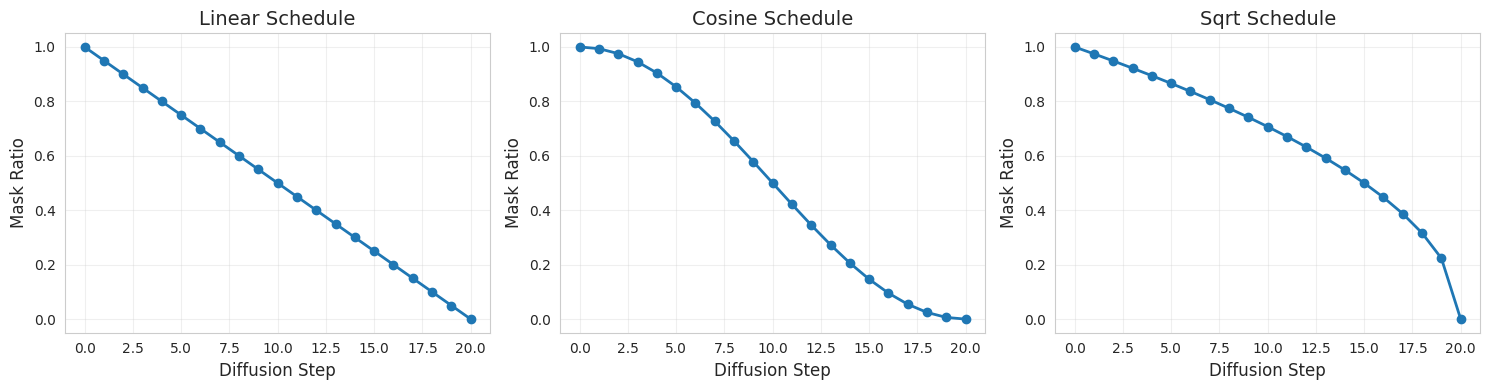

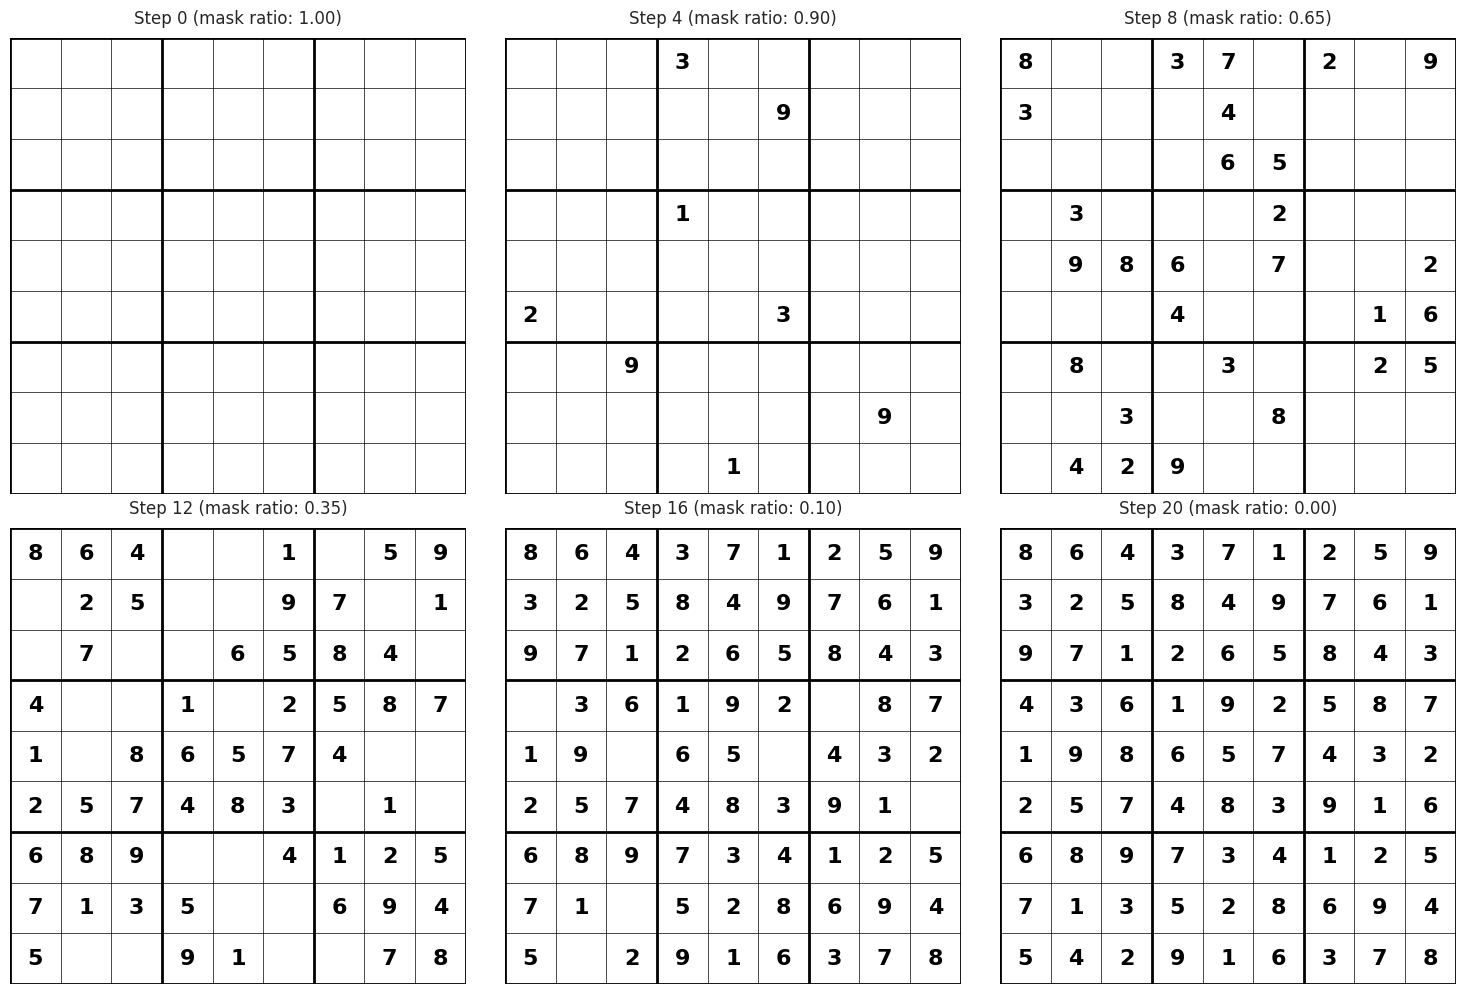

In [6]:
# Test different masking schedules
schedules = ['linear', 'cosine', 'sqrt']
num_steps = 20

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, schedule_type in enumerate(schedules):
    schedule = MaskSchedule(schedule_type, num_steps)
    ratios = [schedule.get_mask_ratio(t) for t in range(num_steps + 1)]
    
    axes[idx].plot(range(num_steps + 1), ratios, 'o-', linewidth=2)
    axes[idx].set_xlabel('Diffusion Step', fontsize=12)
    axes[idx].set_ylabel('Mask Ratio', fontsize=12)
    axes[idx].set_title(f'{schedule_type.capitalize()} Schedule', fontsize=14)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Visualize masking on a sample
puzzle, solution = train_dataset[0]
schedule = MaskSchedule('cosine', 20)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, step in enumerate([0, 4, 8, 12, 16, 20]):
    mask_ratio = schedule.get_mask_ratio(step)
    masked, mask = schedule.apply_mask(solution.unsqueeze(0), mask_ratio)
    
    plot_sudoku_on_axis(axes[i], masked[0], 
                       f"Step {step} (mask ratio: {mask_ratio:.2f})")

plt.tight_layout()
plt.show()


## 6. Train the Model

Let's set up the training loop. For the notebook, we'll train for fewer epochs.

In [7]:
from torch.utils.data import DataLoader

# Training configuration
train_config = {
    'batch_size': 128,
    'num_epochs': 300,  # Reduced for notebook
    'lr': 1e-3,
    'weight_decay': 0,
    'num_diffusion_steps': 20,
    'mask_schedule': 'cosine'
}

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    num_workers=0,  # 0 for notebook compatibility
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training batches: 782
Validation batches: 8


In [8]:
# Create trainer
trainer = MDMTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    lr=train_config['lr'],
    weight_decay=train_config['weight_decay'],
    mask_schedule=train_config['mask_schedule'],
    num_diffusion_steps=train_config['num_diffusion_steps']
)

print("=" * 60)
print("TRAINING SETUP COMPLETE")
print("=" * 60)
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Learning rate: {train_config['lr']}")
print("=" * 60)
print()

# Check if we have a saved checkpoint
checkpoint_path = Path('checkpoints/sudoku_mdm_best.pt')
if checkpoint_path.exists():
    print("Loading existing checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"  Train loss: {checkpoint['train_loss']:.4f}")
    print(f"  Val loss: {checkpoint['val_loss']:.4f}")
    print()
else:
    print("No checkpoint found. Starting training from scratch...")
    print("This may take several minutes. Training...\n")
    
    # Train
    checkpoint_path.parent.mkdir(exist_ok=True)
    trainer.train(
        num_epochs=train_config['num_epochs'],
        save_path=str(checkpoint_path)
    )
    
    # Plot training curves
    print("\n" + "=" * 60)
    print("TRAINING COMPLETE")
    print("=" * 60)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(trainer.train_losses, label='Train Loss', linewidth=2, marker='o')
    ax.plot(trainer.val_losses, label='Val Loss', linewidth=2, marker='s')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Curves', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if len(trainer.train_losses) > 0:
        print(f"\nFinal Train Loss: {trainer.train_losses[-1]:.4f}")
        print(f"Final Val Loss: {trainer.val_losses[-1]:.4f}")
        print(f"Best Val Loss: {min(trainer.val_losses):.4f}")


TRAINING SETUP COMPLETE
Device: cuda
Model parameters: 4,158,346
Train batches: 782
Val batches: 8
Learning rate: 0.001

Loading existing checkpoint...
✓ Loaded checkpoint from epoch 277
  Train loss: 0.9182
  Val loss: 0.1398



## 7. Generate Samples from the Trained Model

Now let's test the model's ability to generate valid Sudoku solutions.

Generating Sudoku solutions from scratch...

Generation Results:
  Total samples: 16
  Valid samples: 0
  Validity rate: 0.0%


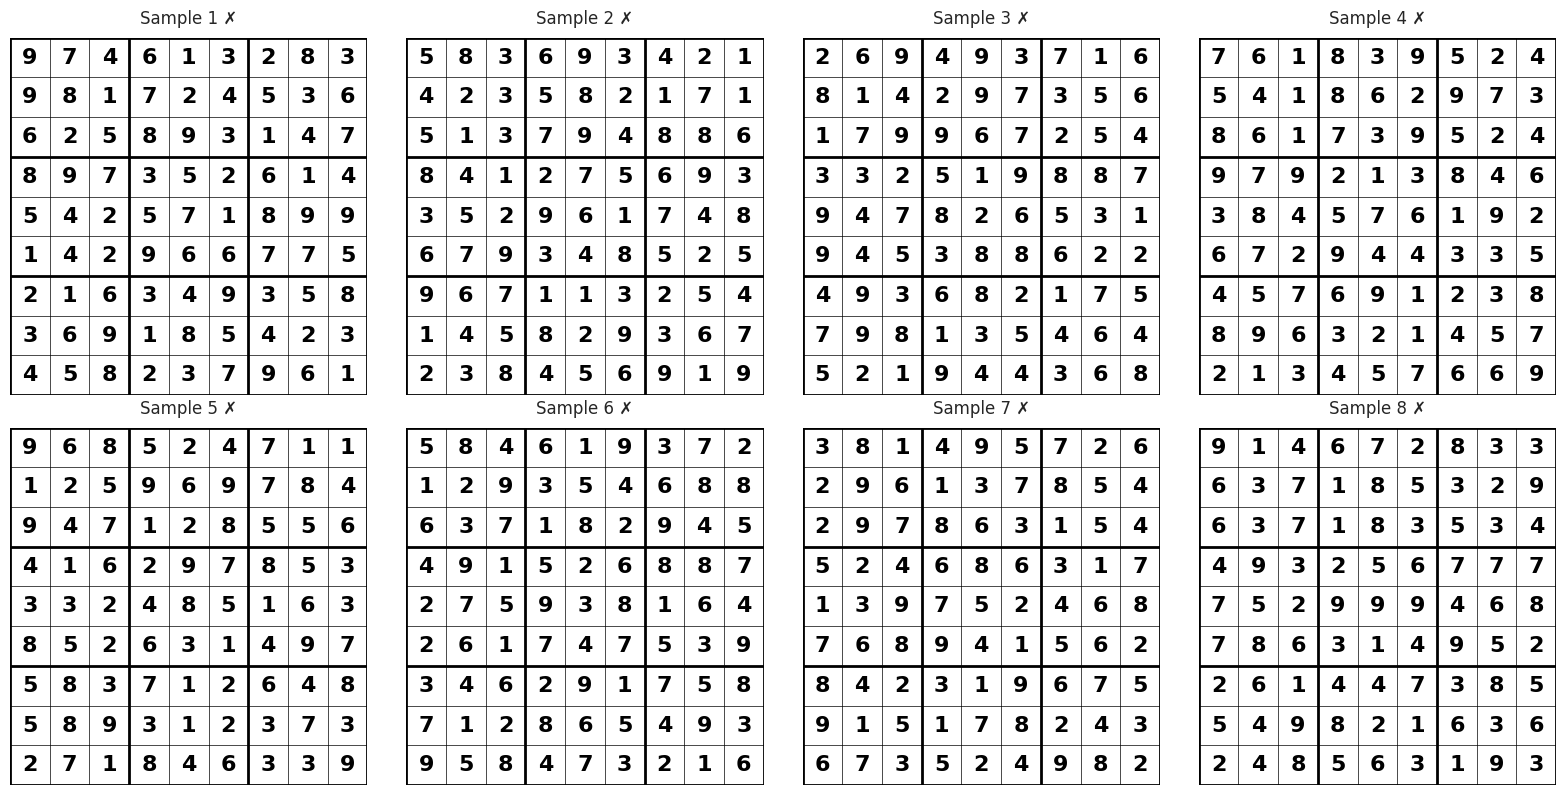

In [9]:
# Create sampler
sampler = MDMSampler(model, device=device)

# Generate from scratch
print("Generating Sudoku solutions from scratch...")
samples = sampler.sample(num_samples=16, num_steps=20, temperature=1.0)

# Evaluate
results = evaluate_samples(samples)
print(f"\nGeneration Results:")
print(f"  Total samples: {results['num_samples']}")
print(f"  Valid samples: {results['num_valid']}")
print(f"  Validity rate: {results['validity_rate']*100:.1f}%")

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    sample = samples[i].cpu()
    is_valid = check_sudoku_valid(sample.numpy())
    title = f"Sample {i+1} {'✓' if is_valid else '✗'}"
    plot_sudoku_on_axis(axes[i], sample, title)

plt.tight_layout()
plt.show()


## 8. Complete a Given Puzzle

Test the model's ability to solve a partial Sudoku puzzle.

Completing puzzle with multiple samples...


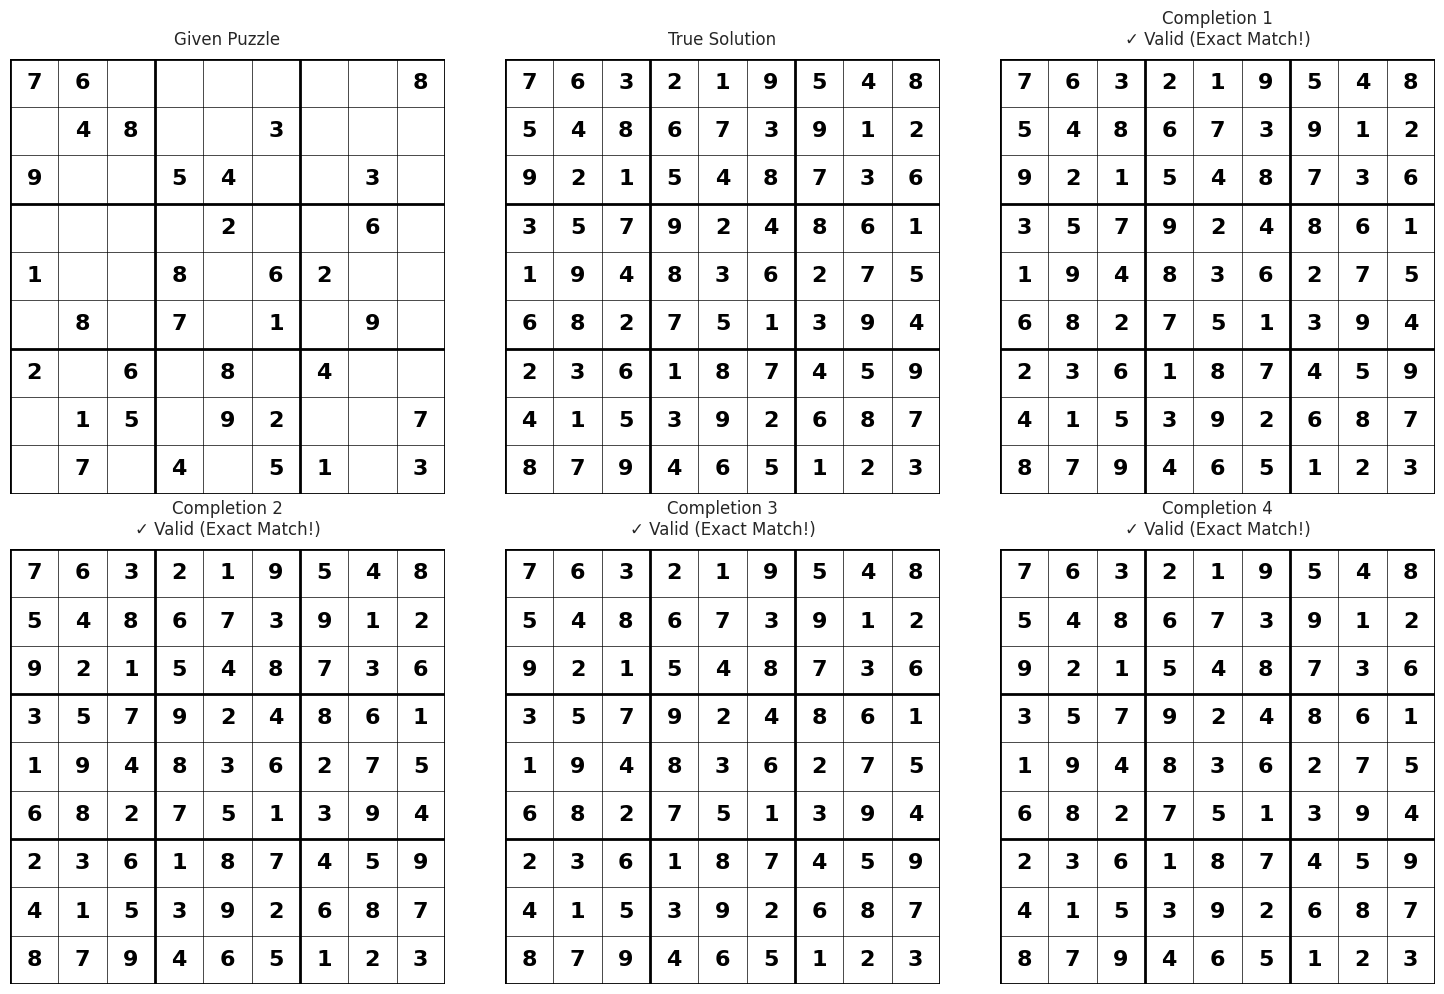

In [17]:
# Get a test puzzle
puzzle, true_solution = val_dataset[7]

# Generate multiple completions
print("Completing puzzle with multiple samples...")
completions = sampler.sample(
    num_samples=4,
    num_steps=81,
    temperature=0.8,
    given_puzzle=puzzle.unsqueeze(0).repeat(4, 1)
)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Show puzzle and true solution
plot_sudoku_on_axis(axes[0], puzzle, "Given Puzzle")
plot_sudoku_on_axis(axes[1], true_solution, "True Solution")

# Show generated completions
for i in range(4):
    completion = completions[i].cpu()
    is_valid = check_sudoku_valid(completion.numpy())
    # Check if it matches the true solution
    matches = torch.all(completion == true_solution).item()
    title = f"Completion {i+1}\n{'✓ Valid' if is_valid else '✗ Invalid'}"
    if matches:
        title += " (Exact Match!)"
    plot_sudoku_on_axis(axes[2+i], completion, title)

plt.tight_layout()
plt.show()


In [16]:
# Iterate through validation set and evaluate
all_results = {
    'num_samples': 0,
    'num_valid': 0,
    'num_exact_matches': 0
}
from tqdm import tqdm
for idx in tqdm(range(len(val_dataset))):
    puzzle, true_solution = val_dataset[idx]
    
    completions = sampler.sample(
        num_samples=4,
        num_steps=81,
        temperature=0.8,
        given_puzzle=puzzle.unsqueeze(0).repeat(4, 1)
    )
    
    results = evaluate_samples(
        completions,
    )

    all_results['num_samples'] += results['num_samples']
    all_results['num_valid'] += results['num_valid']

# Print overall results
validity_rate = all_results['num_valid'] / all_results['num_samples']
print(f"Validity Rate: {validity_rate:.2f}")
#print(f"Exact Match Rate: {exact_match_rate:.2f}")

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]

Validity Rate: 0.93


## 9. Visualize Per-Position Marginal Distributions

This is the key output for MI estimation: p(x_i | context) for each position.

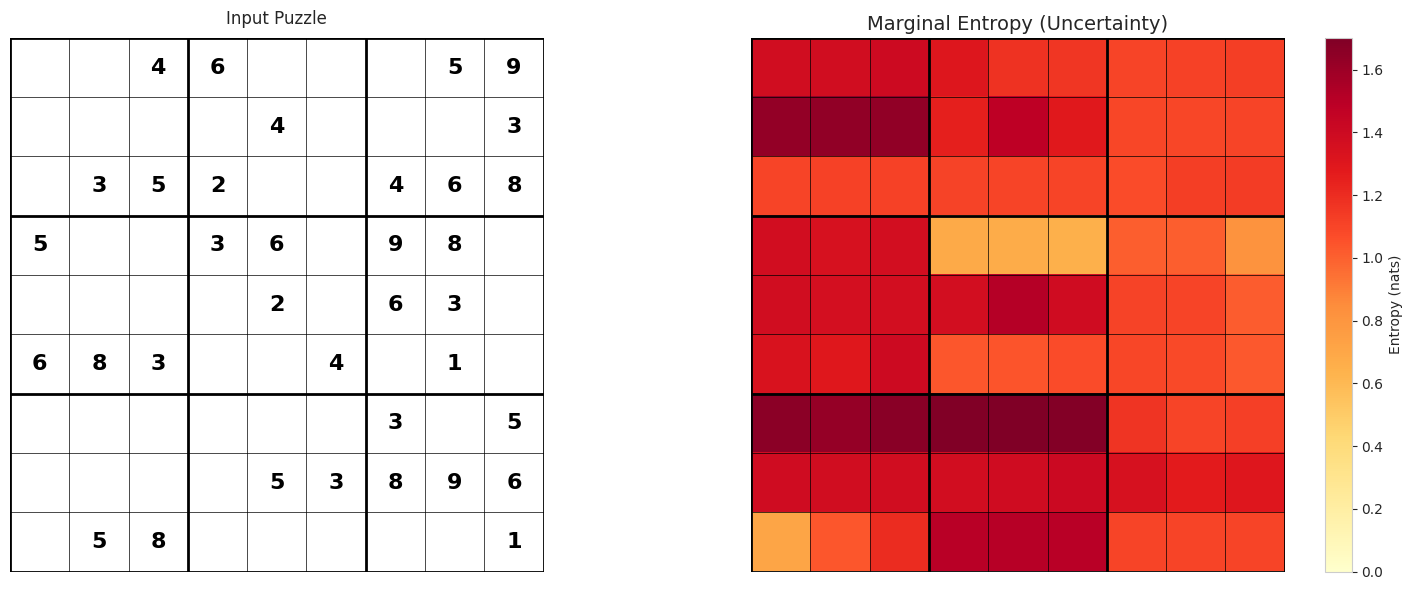

High entropy (red) = high uncertainty
Low entropy (yellow) = confident prediction


In [17]:
# Get marginals for a partially filled puzzle
puzzle, solution = val_dataset[5]

# Get marginals
with torch.no_grad():
    marginals = sampler.get_marginals(puzzle.unsqueeze(0))  # [1, 81, 10]

marginals = marginals[0].cpu().numpy()  # [81, 10]

# Visualize marginals for each position
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: show the puzzle
plot_sudoku_on_axis(axes[0], puzzle, "Input Puzzle")

# Right: show entropy map (uncertainty)
entropy = -np.sum(marginals * np.log(marginals + 1e-10), axis=1)
entropy_map = entropy.reshape(9, 9)

im = axes[1].imshow(entropy_map, cmap='YlOrRd', vmin=0, vmax=entropy.max())
axes[1].set_title('Marginal Entropy (Uncertainty)', fontsize=14)
axes[1].axis('off')

# Draw grid
for i in range(10):
    lw = 2 if i % 3 == 0 else 0.5
    axes[1].axhline(i - 0.5, color='black', linewidth=lw)
    axes[1].axvline(i - 0.5, color='black', linewidth=lw)

plt.colorbar(im, ax=axes[1], label='Entropy (nats)')
plt.tight_layout()
plt.show()

print("High entropy (red) = high uncertainty")
print("Low entropy (yellow) = confident prediction")


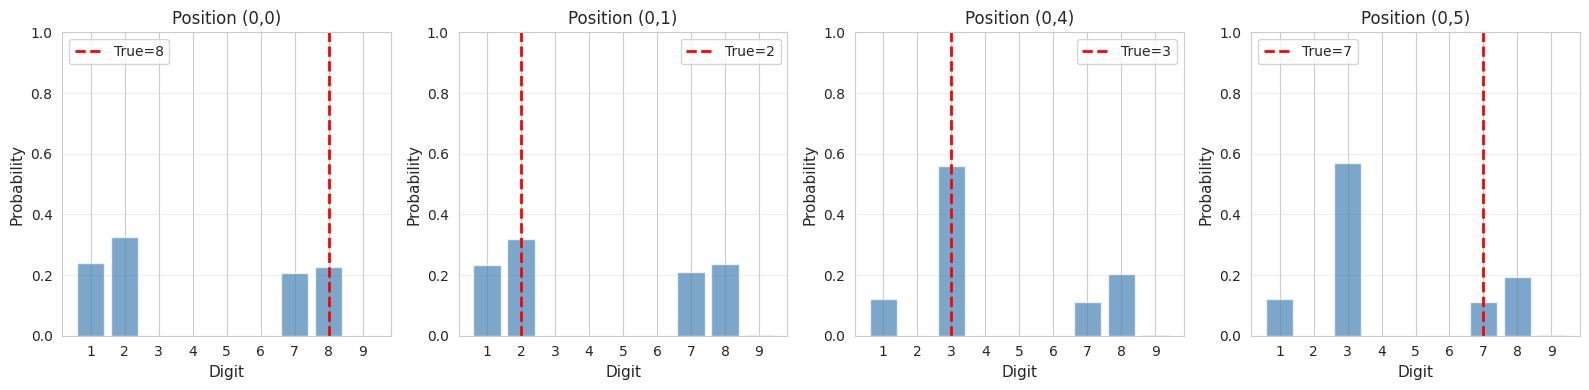

In [18]:
# Visualize marginals for specific positions
puzzle_2d = puzzle.reshape(9, 9).numpy()

# Find a few masked positions
masked_positions = np.where(puzzle_2d == 0)
if len(masked_positions[0]) >= 4:
    positions_to_show = [(masked_positions[0][i], masked_positions[1][i]) for i in range(min(4, len(masked_positions[0])))]
else:
    positions_to_show = [(4, 4), (0, 0), (8, 8), (5, 3)]  # Default positions

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (i, j) in enumerate(positions_to_show):
    pos = i * 9 + j
    probs = marginals[pos, 1:]  # Exclude MASK token
    
    axes[idx].bar(range(1, 10), probs, color='steelblue', alpha=0.7)
    axes[idx].set_xlabel('Digit', fontsize=11)
    axes[idx].set_ylabel('Probability', fontsize=11)
    axes[idx].set_title(f'Position ({i},{j})', fontsize=12)
    axes[idx].set_xticks(range(1, 10))
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Highlight true value if known
    true_val = solution.reshape(9, 9)[i, j].item()
    if true_val > 0:
        axes[idx].axvline(true_val, color='red', linestyle='--', linewidth=2, 
                         label=f'True={true_val}')
        axes[idx].legend()

plt.tight_layout()
plt.show()


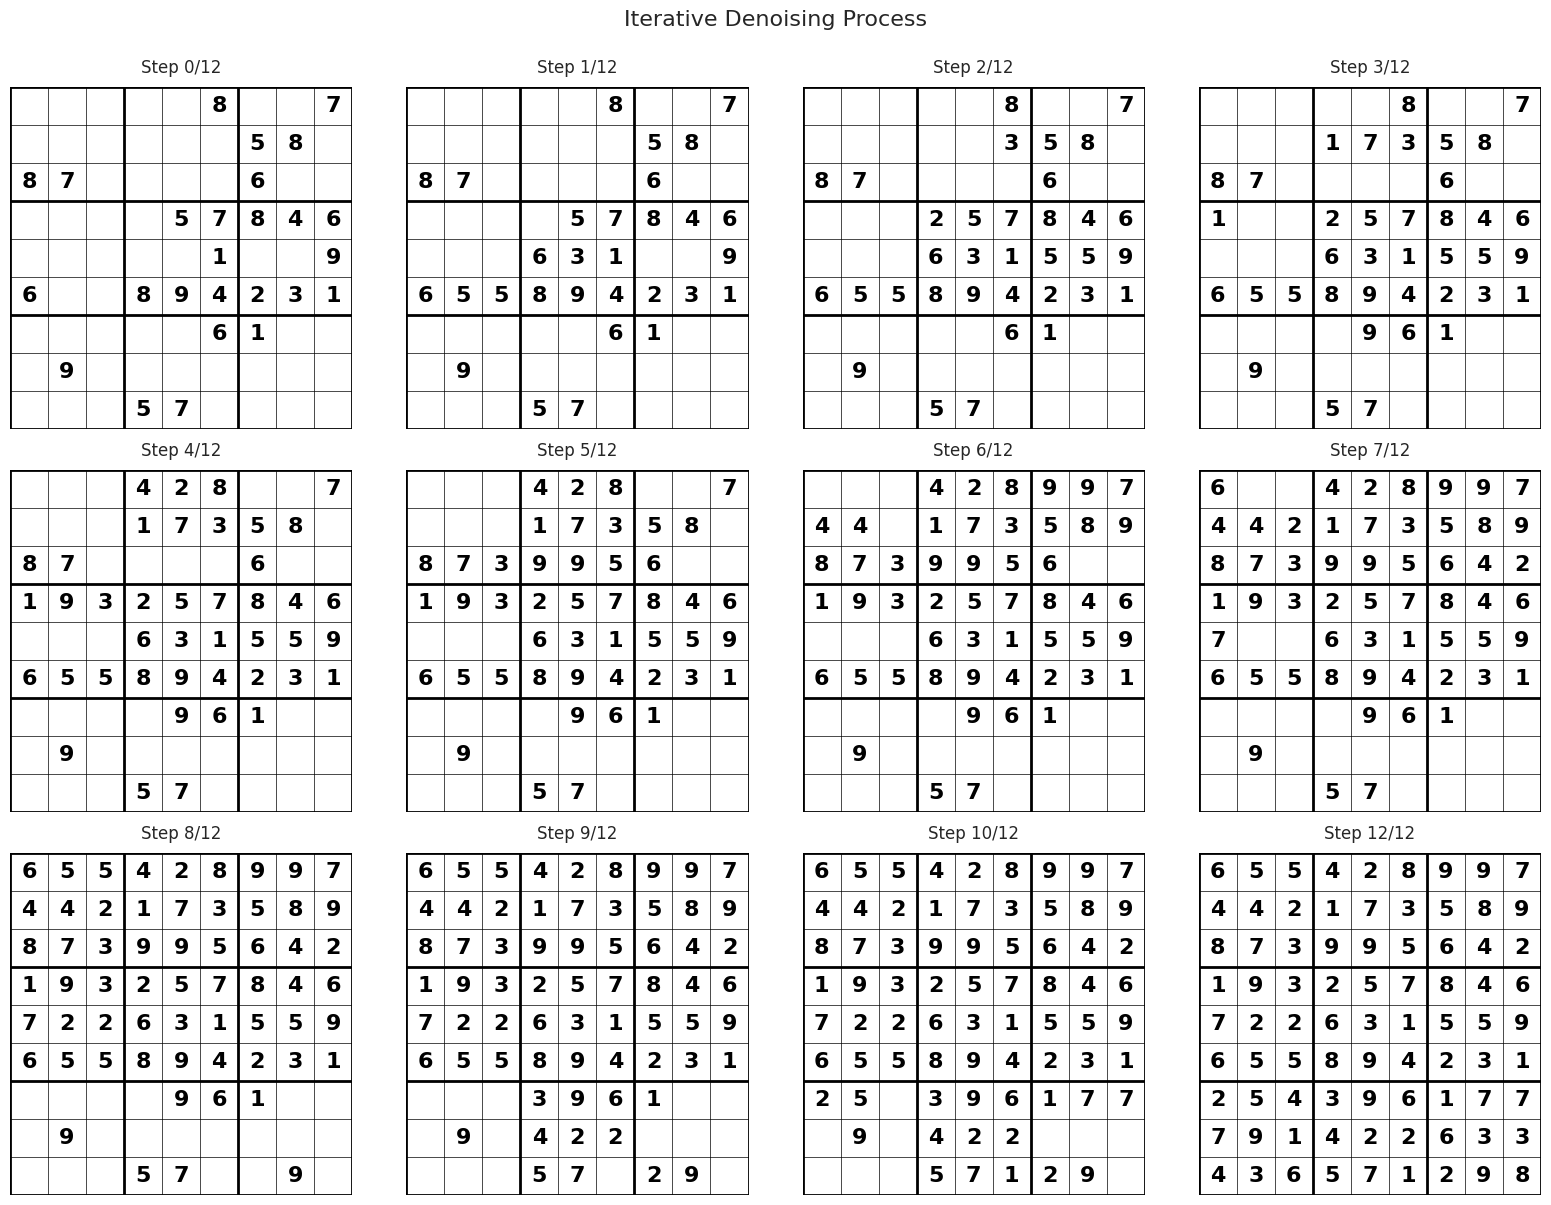

Final solution valid: False


In [19]:
# Manually run the denoising process step-by-step
puzzle, solution = val_dataset[10]

num_steps = 12
x = puzzle.unsqueeze(0).to(device)
fixed_mask = (x != 0)

# Store states
states = [x.cpu().clone()]
marginal_snapshots = []

with torch.no_grad():
    for step in range(num_steps):
        # Get marginals
        marginals_step = sampler.get_marginals(x)
        marginal_snapshots.append(marginals_step.cpu().clone())
        
        # Find masked positions
        mask = (x == 0) & (~fixed_mask)
        
        if not mask.any():
            break
        
        # Number of positions to unmask
        num_masked = mask.sum(dim=1)
        num_unmask = (num_masked * (1.0 / (num_steps - step))).long()
        
        # Unmask top confident positions
        for i in range(x.size(0)):
            if num_unmask[i] == 0:
                continue
            
            masked_positions = mask[i].nonzero(as_tuple=True)[0]
            if len(masked_positions) == 0:
                continue
            
            # Confidence scores
            confidence = marginals_step[i, masked_positions, 1:].max(dim=-1)[0]
            
            # Select top-k
            k = min(num_unmask[i].item(), len(masked_positions))
            top_k = confidence.topk(k).indices
            positions_to_unmask = masked_positions[top_k]
            
            # Sample tokens
            sampled_tokens = torch.multinomial(
                marginals_step[i, positions_to_unmask, 1:],
                num_samples=1
            ).squeeze(-1) + 1
            
            x[i, positions_to_unmask] = sampled_tokens
        
        states.append(x.cpu().clone())

# Visualize the process
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

steps_to_show = np.linspace(0, len(states)-1, 12).astype(int)

for idx, step_idx in enumerate(steps_to_show):
    if step_idx < len(states):
        state = states[step_idx][0]
        plot_sudoku_on_axis(axes[idx], state, f"Step {step_idx}/{len(states)-1}")

plt.suptitle("Iterative Denoising Process", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

print(f"Final solution valid: {check_sudoku_valid(states[-1][0].numpy())}")


In [20]:
# Example: Extract marginals for multiple contexts
num_contexts = 5
contexts = []
all_marginals = []

for i in range(num_contexts):
    puzzle, solution = val_dataset[i]
    with torch.no_grad():
        marginals = sampler.get_marginals(puzzle.unsqueeze(0))
    contexts.append(puzzle)
    all_marginals.append(marginals[0])

all_marginals = torch.stack(all_marginals)  # [num_contexts, 81, 10]

print(f"Extracted marginals shape: {all_marginals.shape}")
print(f"  - {num_contexts} different contexts (puzzle configurations)")
print(f"  - 81 positions per context")
print(f"  - 10 vocabulary items (0=MASK, 1-9=digits)")
print("\nThese marginals are the foundation for MI estimation!")


Extracted marginals shape: torch.Size([5, 81, 10])
  - 5 different contexts (puzzle configurations)
  - 81 positions per context
  - 10 vocabulary items (0=MASK, 1-9=digits)

These marginals are the foundation for MI estimation!


In [10]:
def estimate_joint_mc(sampler, context, pos_i, pos_j, num_samples=1000):
    """
    Estimate joint distribution p(x_i, x_j | context) via Monte Carlo sampling.
    
    Args:
        sampler: MDMSampler instance
        context: [81] tensor - the context configuration
        pos_i, pos_j: position indices
        num_samples: number of samples for MC estimation
        
    Returns:
        joint: [9, 9] numpy array - estimated joint probabilities
        marginal_i: [9] - marginal for position i
        marginal_j: [9] - marginal for position j
    """
    # Generate samples from the model
    samples = sampler.sample(
        num_samples=num_samples,
        num_steps=20,
        temperature=1.0,
        given_puzzle=context.unsqueeze(0).repeat(num_samples, 1)
    )
    
    # Extract values at positions i and j
    values_i = samples[:, pos_i].cpu().numpy()  # [num_samples]
    values_j = samples[:, pos_j].cpu().numpy()  # [num_samples]
    
    # Estimate joint (excluding MASK token = 0)
    joint = np.zeros((9, 9))
    for vi, vj in zip(values_i, values_j):
        if vi > 0 and vj > 0:  # Valid digits
            joint[vi-1, vj-1] += 1
    
    joint = joint / joint.sum()  # Normalize
    
    # Marginals from joint
    marginal_i = joint.sum(axis=1)
    marginal_j = joint.sum(axis=0)
    
    return joint, marginal_i, marginal_j


def compute_mi_from_joint(joint, marginal_i, marginal_j):
    """Compute MI from joint distribution."""
    mi = 0.0
    for i in range(9):
        for j in range(9):
            if joint[i, j] > 0:
                mi += joint[i, j] * np.log(joint[i, j] / (marginal_i[i] * marginal_j[j] + 1e-10))
    return mi


# Example: Estimate MI between two positions
puzzle, solution = val_dataset[0]
pos_i, pos_j = 40, 41  # Two adjacent positions in middle row

print(f"Estimating joint for positions {pos_i} and {pos_j}...")
print("This may take a minute...")

joint, marg_i, marg_j = estimate_joint_mc(sampler, puzzle, pos_i, pos_j, num_samples=500)
mi_estimate = compute_mi_from_joint(joint, marg_i, marg_j)

print(f"\nMI estimate: {mi_estimate:.4f} nats")
print(f"MI in bits: {mi_estimate / np.log(2):.4f}")

# Visualize the joint
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Joint distribution
im0 = axes[0].imshow(joint, cmap='Blues', vmin=0, vmax=joint.max())
axes[0].set_xlabel(f'Position {pos_j}', fontsize=12)
axes[0].set_ylabel(f'Position {pos_i}', fontsize=12)
axes[0].set_title('Joint Distribution p(x_i, x_j | c)', fontsize=12)
axes[0].set_xticks(range(9))
axes[0].set_yticks(range(9))
axes[0].set_xticklabels(range(1, 10))
axes[0].set_yticklabels(range(1, 10))
plt.colorbar(im0, ax=axes[0])

# Marginal i
axes[1].bar(range(1, 10), marg_i, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Digit', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title(f'Marginal p(x_{pos_i} | c)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Marginal j
axes[2].bar(range(1, 10), marg_j, color='coral', alpha=0.7)
axes[2].set_xlabel('Digit', fontsize=12)
axes[2].set_ylabel('Probability', fontsize=12)
axes[2].set_title(f'Marginal p(x_{pos_j} | c)', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Estimating joint for positions 40 and 41...
This may take a minute...


NameError: name 'sampler' is not defined

Computing MI for different position pair types...
(Using fewer samples for speed - increase for accuracy)

Computing Same Row: positions (0, 1)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Same Column: positions (0, 9)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Same Column: positions (0, 9)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Same Box: positions (0, 10)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Same Box: positions (0, 10)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Different Box: positions (0, 80)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Different Box: positions (0, 80)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Adjacent: positions (40, 41)...
  MI = -0.0000 nats (-0.0000 bits)

Computing Adjacent: positions (40, 41)...
  MI = 0.0727 nats (0.1049 bits)

  MI = 0.0727 nats (0.1049 bits)



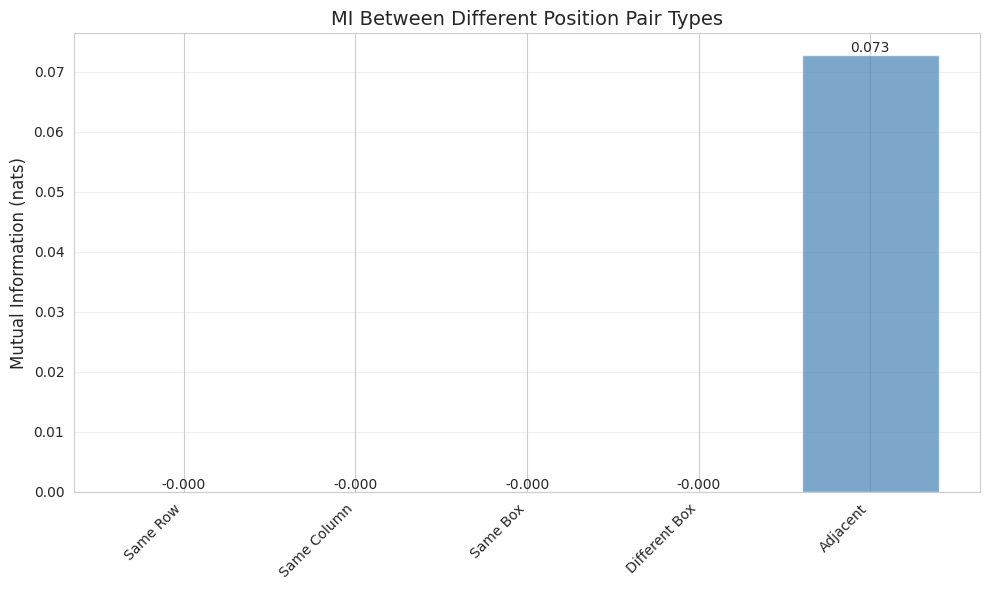


Observations:
- Positions in the same constraint (row/column/box) should have higher MI
- Distant positions in different boxes should have lower MI
- This dependency structure is what our MI estimators will learn!


In [22]:
# Compare MI for different types of position pairs
puzzle, solution = val_dataset[0]

# Define interesting pairs
pairs = {
    'Same Row': (0, 1),       # Row 0, positions 0 and 1
    'Same Column': (0, 9),    # Column 0, positions 0 and 9
    'Same Box': (0, 10),      # Top-left box
    'Different Box': (0, 80), # Corners
    'Adjacent': (40, 41),     # Middle row, adjacent
}

mi_results = {}

print("Computing MI for different position pair types...")
print("(Using fewer samples for speed - increase for accuracy)\n")

for name, (i, j) in pairs.items():
    print(f"Computing {name}: positions ({i}, {j})...")
    joint, marg_i, marg_j = estimate_joint_mc(sampler, puzzle, i, j, num_samples=200)
    mi = compute_mi_from_joint(joint, marg_i, marg_j)
    mi_results[name] = mi
    print(f"  MI = {mi:.4f} nats ({mi/np.log(2):.4f} bits)\n")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
names = list(mi_results.keys())
mis = list(mi_results.values())

bars = ax.bar(names, mis, color='steelblue', alpha=0.7)
ax.set_ylabel('Mutual Information (nats)', fontsize=12)
ax.set_title('MI Between Different Position Pair Types', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mi in zip(bars, mis):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mi:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Positions in the same constraint (row/column/box) should have higher MI")
print("- Distant positions in different boxes should have lower MI")
print("- This dependency structure is what our MI estimators will learn!")


## Summary

We've successfully implemented a **Masked Diffusion Model for Sudoku**! 

### What We Have:
✅ Trained MDM that generates valid Sudoku solutions  
✅ Per-position marginal distributions p(x_i | c)  
✅ Sampling capability for joint distribution estimation  
✅ MC-based MI computation between position pairs  

### What's Next:
The three MI estimation approaches:

**Option A**: Train f_φ to predict log p(x_i, x_j | c) directly  
**Option B1**: Transformer that maps marginals → full MI matrix  
**Option B2**: Siamese network for pairwise marginal → MI  

All three options can now be implemented using this MDM as the foundation!

## 13. Analyze MI Structure in Sudoku

Let's compute MI for several position pairs to understand the dependency structure.

## 12. Estimate Joint Distribution via Monte Carlo

To train MI estimators, we need ground truth. Let's demonstrate how to estimate p(x_i, x_j | c) via sampling.

## 11. Prepare for Mutual Information Estimation

Now that we have a trained MDM that outputs per-position marginals p(x_i | c), we can prepare for MI estimation between positions.

### Key Capabilities
1. **Marginal extraction**: `model.get_marginals(x)` gives us p(x_i | c) for all positions
2. **Sampling**: We can sample from the model to estimate joint distributions p(x_i, x_j | c)
3. **Contexts**: Different puzzle configurations provide different contexts

### Next Steps for MI Estimation

**Option A - Learn log-joint**: Train a neural network to predict log p(x_i, x_j | c) using Monte Carlo samples

**Option B1 - Sequence → MI matrix**: Feed all marginals into a transformer that outputs the full MI matrix

**Option B2 - Pairwise MI function**: Use Siamese encoders on pairs of marginals to predict MI(i,j)

## 10. Visualize Iterative Denoising Process

Watch how marginals evolve during the sampling process.